In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,\
                      GRU, Dropout,GlobalAveragePooling1D, Conv1D, TimeDistributed,\
                      Input, Concatenate, GlobalMaxPooling1D
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import re
from nltk import sent_tokenize, word_tokenize, pos_tag, ne_chunk
import nltk.data
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
from nltk.chunk.util import ChunkScore
import pickle
import math
import string
#import collections.Iterable as Iterable

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from nltk.chunk import conlltags2tree, tree2conlltags

import gzip
from lxml import etree
from tqdm import tqdm
import random
from collections import Counter

%load_ext autoreload
%autoreload 2
import os, inspect, sys
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from unwiki import unwiki
import ner
from embed_utils import open_w2v
import clean_and_token_text as clean

In [2]:
#with open('/media/hd1/wikipedia/wiki_definitions_improved.txt', 'r') as wiki_f:
#    wiki = wiki_f.readlines()

cfg = {}

wiki = []
with gzip.open('/media/hd1/wikipedia/wiki_definitions_improved.xml.gz', 'r') as xml_fobj:
    def_xml = etree.parse(xml_fobj)
    for art in def_xml.findall('definition'):
        data = (art.find('.//dfndum').text, '', art.find('.//stmnt').text)
        wiki.append(data)

def split_fields(elem):
    title = elem.find('.//dfndum').text 
    section = elem.get('name')
    defin = elem.find('.//stmnt').text
    return (title, section, defin)

plmath = []
with gzip.open('/media/hd1/planetmath/datasets/planetmath_definitions.xml.gz', 'r') as xml_fobj:
    def_xml = etree.parse(xml_fobj)
    for art in def_xml.findall('article'):
        plmath.append(split_fields(art))
stacks = []
with gzip.open('/media/hd1/stacks-project/datasets/stacks-definitions.xml.gz', 'r') as xml_fobj:
    def_xml = etree.parse(xml_fobj)
    for art in def_xml.findall('article'):
        try:
            stacks.append(split_fields(art))
        except AttributeError:
            print('The name of the problematic article is: {}'.format(art.attrib['name']))

text_lst = wiki + plmath + stacks
random.shuffle(text_lst)

# Get data and train the Sentence tokenizer
# Uses a standard algorithm (Kiss-Strunk) for unsupervised sentence boundary detection
text = ''
for i in range(3550):
    text += text_lst[i][2]

trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = True
trainer.train(text)
sent_tok = PunktSentenceTokenizer(trainer.get_params())
print(sent_tok._params.abbrev_types)

def_lst = ner.bio_tag.put_pos_ner_tags(text_lst, sent_tok)

# Finding the POS set 
pos_cnt = Counter()
for Def in def_lst:
    pos_cnt.update([el[0][1] for el in Def['ner']])
print("Found {} alphanum POS tags in the data, the most common are: {}"\
      .format(len(pos_cnt), pos_cnt.most_common()[:10]))
pos_lst = list(pos_cnt)
pos_ind_dict = {pos: k for k, pos in enumerate(pos_lst)}

The name of the problematic article is: examples.xml
The name of the problematic article is: coding.xml
The name of the problematic article is: spaces-pushouts.xml
The name of the problematic article is: guide.xml
The name of the problematic article is: moduli.xml
The name of the problematic article is: more-groupoids.xml
The name of the problematic article is: chapters.xml
The name of the problematic article is: sets.xml
The name of the problematic article is: obsolete.xml
The name of the problematic article is: examples-defos.xml
The name of the problematic article is: spaces-more-cohomology.xml
The name of the problematic article is: bibliography.xml
The name of the problematic article is: fdl.xml
The name of the problematic article is: limits.xml
The name of the problematic article is: conventions.xml
The name of the problematic article is: introduction.xml
The name of the problematic article is: quot.xml
The name of the problematic article is: desirables.xml
{'resp', 'inc', 'i.w.w

In [3]:
with open_w2v('/media/hd1/embeddings/model4ner_19-33_02-01/vectors.bin') as embed_dict:
    wind = ['<UNK>',] + list(embed_dict.keys())
    cfg['emb_nvocab'] = len(wind) 
    embed_matrix = np.zeros((cfg['emb_nvocab'], 200))
    for word, vec in embed_dict.items():
        #vect = embed_dict.get(word)
        ind = wind.index(word)
            #vect = vect/np.linalg.norm(vect)
        embed_matrix[ind] = vec
#print("Coverage of embed is: {}".format(coverage_cnt/len(embed_dict)))

Vocabulary size: 208442 and dimension of embed: 200


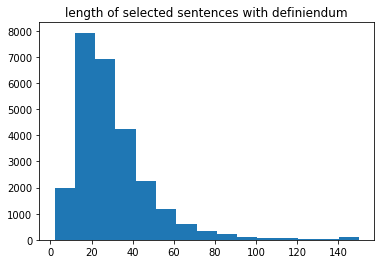

In [4]:
sent_lengths = []
for d in def_lst:
    slen = min(len(d['ner']), 150)
    sent_lengths.append(slen)
plt.hist(sent_lengths, bins=15)
plt.title('length of selected sentences with definiendum')
plt.show()

In [5]:
cfg['padseq'] = {'maxlen': 50 , 'padding': 'post', 'truncating': 'post'}
cfg['n_tags'] = 2

# shuffle def_lst
random.shuffle(def_lst)

cfg['train_test_split'] = 0.9
r_def_lst = range(len(def_lst))
TVT_len = int(cfg['train_test_split']*len(def_lst))
r_train = r_def_lst[:TVT_len]
r_valid = r_def_lst[TVT_len:]
r_test = r_valid[:int(0.5*len(r_valid))]
r_valid = r_valid[int(0.5*len(r_valid)):]
log_str = 'Original Range: {}\n Training: {}  Validation: {}  Test: {} \n'\
              .format(repr(r_def_lst), repr(r_train), repr(r_test), repr(r_valid)) 
print(log_str)

train_def_lst = [def_lst[k] for k in r_train]
test_def_lst = [def_lst[k] for k in r_test]
valid_def_lst = [def_lst[k] for k in r_valid]

def prep_data(dat, wind, cfg, *args):
    '''
   dat should be in the "ner" format
    '''
    if isinstance(dat, str):
        dat_tok = word_tokenize(dat)
        norm_words = [clean.normalize_text(d).strip() for d in dat_tok]
        labels = [False for d in dat]
    else:
        norm_words = [clean.normalize_text(d[0][0]).strip() for d in dat]
        labels = [d[1] != 'O' for d in dat]
    ind_words = []
    for w in norm_words:
        try:
            ind_words.append(wind.index(w))
        except ValueError:
            ind_words.append(0)
    return ind_words, labels

def prep_pos(dat, pos_ind_dict):
    '''
    dat is in the format:
    [(('In', 'IN'), 'O'),
     (('Southern', 'NNP'), 'O'),
     (('Africa', 'NNP'), 'O'),
     ((',', ','), 'O'),
     (('the', 'DT'), 'O'),
     (('word', 'NN'), 'O')]
    '''
    out_lst = []
    for d in dat:
        out_lst.append(pos_ind_dict[d[0][1]])
    return out_lst

#binary_fun_lst = [
#    lambda w: word[0] in string.ascii_uppercase,  # Capitalized
#]
def binary_features(dat):
    out_lst = []
    for d in dat:
        word =d[0][0]
        capitalized = float(word[0] in string.ascii_uppercase)
        contains_dash = float('-' in word)
        
        out_lst.append((capitalized, contains_dash))
    return out_lst

cfg['nbin_feats'] = 2 # number of binary features defined in the function above
    
def prep_data4real(_def_lst, wind, cfg):
    _data = [prep_data(d['ner'], wind, cfg) for d in _def_lst]
    _seq, _lab = zip(*_data)
    _pos_seq = [prep_pos(d['ner'], pos_ind_dict) for d in _def_lst]
    _bin_seq = [binary_features(d['ner']) for d in _def_lst]
    # PAD THE SEQUENCES
    _seq = pad_sequences(_seq, **cfg['padseq'])
    _pos_seq = pad_sequences(_pos_seq, **cfg['padseq'])
    _bin_seq = pad_sequences(_bin_seq, **cfg['padseq'],
                                  value = cfg['nbin_feats']*[0.0],
                                 dtype='float32')
    _lab = pad_sequences(_lab, **cfg['padseq'])
    return _seq, _pos_seq, _bin_seq, _lab

train_seq, train_pos_seq, train_bin_seq , train_lab = prep_data4real(train_def_lst, wind, cfg)
test_seq, test_pos_seq, test_bin_seq , test_lab = prep_data4real(test_def_lst, wind, cfg)
valid_seq, valid_pos_seq, valid_bin_seq , valid_lab = prep_data4real(valid_def_lst, wind, cfg)

## Create Train data
#train_data = [prep_data(d['ner'], wind, cfg) for d in train_def_lst]
#train_seq, train_lab = zip(*train_data)
#train_pos_seq = [prep_pos(d['ner'], pos_ind_dict) for d in train_def_lst]
#train_bin_seq = [binary_features(d['ner']) for d in train_def_lst]
#cfg['nbin_feats'] = len(train_bin_seq[0][0])
## Pad it
#train_seq = pad_sequences(train_seq, **cfg['padseq'])
#train_pos_seq = pad_sequences(train_pos_seq, **cfg['padseq'])
#train_bin_seq = pad_sequences(train_bin_seq, **cfg['padseq'],
#                              value = cfg['nbin_feats']*[0.0],
#                             dtype='float32')
#train_lab = pad_sequences(train_lab, **cfg['padseq'])
##train_lab = np.array([to_categorical(s, num_classes=cfg['n_tags']) for s in train_lab])
#
## Create Test data
#test_data = [prep_data(d['ner'], wind, cfg) for d in test_def_lst]
#test_seq, test_lab = zip(*test_data)
#test_pos_seq = [prep_pos(d['ner'], pos_ind_dict) for d in test_def_lst]
#test_bin_seq = [binary_features(d['ner']) for d in test_def_lst]
## Pad it
#test_seq = pad_sequences(test_seq, **cfg['padseq'])
#test_pos_seq = pad_sequences(test_pos_seq, **cfg['padseq'])
#test_bin_seq = pad_sequences(test_bin_seq, **cfg['padseq'],
#                             value = cfg['nbin_feats']*[0.0],
#                            dtype='float32')
#test_lab = pad_sequences(test_lab, **cfg['padseq'])
#test_lab = np.array([to_categorical(s, num_classes=cfg['n_tags']) for s in test_lab])

Original Range: range(0, 26108)
 Training: range(0, 23497)  Validation: range(23497, 24802)  Test: range(24802, 26108) 



### TODO
* Right the different concatenated pieces are in different orders of magnitude. Normalization might help
* Search for a minimal stemmer that strips plural or adverbial suffices for example zero-sum games in zero-sum game or absolute continuity and absolute continuous

In [6]:
%%script echo Skip this
# Train NER model
cfg['learning_rate'] = 0.1
model = NerModel(64, len(word_tok.word_index)+1, 4, 100)
optimizer = tf.keras.optimizers.Adam()
def train_one_step(text_batch, labels_batch):
    with tf.GradientTape() as tape:
        logits, text_lens, log_likelihood = model(text_batch, labels_batch, training=True)
        loss = - tf.reduce_mean(log_likelihood)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, logits, text_lens

def get_acc_one_step(logits, text_lens, labels_batch):
    paths = []
    accuracy = 0
    for logit, text_len, labels in zip(logits, text_lens, labels_batch):
        viterbi_path, _ = tfa.text.viterbi_decode(logit[:text_len], model.transition_params)
        paths.append(viterbi_path)
        correct_prediction = tf.equal(
            tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([viterbi_path],
                                                            padding='post'), dtype=tf.int32),
            tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([labels[:text_len]],
                                                            padding='post'), dtype=tf.int32)
        )
        accuracy = accuracy + tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        # print(tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))
    accuracy = accuracy / len(paths)
    return accuracy

best_acc = 0
step = 0
epochs = 20
bs = 1000
for epoch in range(epochs):
    for (text_batch, labels_batch) in \
    [[train_seq2[bs*i:bs*(i+1)], train_lab2[bs*i:bs*(i+1)]]\
     for i in range(math.ceil(len(train_seq2)/bs))]:
        step = step + 1
        loss, logits, text_lens = train_one_step(text_batch, labels_batch)
        if step % 20 == 0:
            accuracy = get_acc_one_step(logits, text_lens, labels_batch)
            print('epoch %d, step %d, loss %.4f , accuracy %.4f' % (epoch, step, loss, accuracy))
            if accuracy > best_acc:
                best_acc = accuracy
                #ckpt_manager.save()
                print("model saved")

Skip this


In [7]:
cfg.update({'input_dim': len(wind),
      'output_dim': 200,
     'input_length': cfg['padseq']['maxlen'],
     'pos_dim': 3,
            'pos_constraint': 1/200,
     'n_tags': 2,
     'batch_size': 2000,
     'lstm_units': 150,
      'adam': {'lr': 0.025, 'beta_1': 0.9, 'beta_2': 0.999}})

In [8]:
def bilstm_lstm_model_w_pos(cfg_dict):
    
    words_in = Input(shape=(cfg_dict['input_length'], ), name='words-in')
    pos_in = Input(shape=(cfg_dict['input_length'], ), name='pos-in')
    bin_feats = Input(shape=(cfg_dict['input_length'], cfg_dict['nbin_feats']), name='bin-features-in')
    
    word_embed = Embedding(cfg_dict['input_dim'], 
                        output_dim=cfg_dict['output_dim'],
                        input_length=cfg_dict['input_length'],
                       weights = [embed_matrix],
                       trainable = False,
                          name='word-embed')(words_in)
    pos_embed = Embedding(len(pos_cnt), 
                        output_dim=cfg_dict['pos_dim'],
                        input_length=cfg_dict['input_length'],
                          embeddings_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),
                       trainable = True,
                         name='pos-embed')(pos_in)
    full_embed = Concatenate(axis=2)([word_embed, pos_embed, bin_feats])
    
    
    out = Bidirectional(LSTM(units=cfg['lstm_units'],
                                 return_sequences=True,
                                 dropout=0.2, 
                                 recurrent_dropout=0.2),
                        merge_mode = 'concat')(full_embed)
    #out = GlobalMaxPooling1D(out) 
    # Add LSTM
    out = Bidirectional(LSTM(units=cfg['lstm_units'],
                   return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
                   recurrent_initializer='glorot_uniform'),
                        merge_mode = 'concat')(out)
    # Add timeDistributed Layer
    out = TimeDistributed(Dense(10, activation="relu"))(out)
    out = TimeDistributed(Dense(1, activation="sigmoid"))(out)
    #Optimiser 
    adam = Adam(**cfg['adam'])
    # Compile model
    bce = tf.keras.losses.BinaryCrossentropy()  #(sample_weight=[0.3, 0.7])
    model = Model([words_in, pos_in, bin_feats], out)
    model.compile(loss = bce,   #'binary_crossentropy',
                  optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model
with_pos = bilstm_lstm_model_w_pos(cfg)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words-in (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
pos-in (InputLayer)             [(None, 50)]         0                                            
__________________________________________________________________________________________________
word-embed (Embedding)          (None, 50, 200)      41688600    words-in[0][0]                   
__________________________________________________________________________________________________
pos-embed (Embedding)           (None, 50, 3)        135         pos-in[0][0]                     
______________________________________________________________________________________________

In [28]:
#res = with_pos.fit([train_seq, train_pos_seq, train_bin_seq], train_lab, verbose=1, epochs=30,
#                batch_size=cfg['batch_size'],
#                validation_data=([test_seq, test_pos_seq, test_bin_seq], test_lab))

# Load weights instead of fitting
res = with_pos.load_weights('/home/luis/rm_me_data/with_pos')

In [10]:
%%script echo skip this
# DEFINE MODEL WITH biLSTM AND TRAIN FUNCTION    
def get_bilstm_lstm_model(cfg_dict):
    model = Sequential()
    # Add Embedding layer
    model.add(Embedding(cfg_dict['input_dim'], 
                        output_dim=cfg_dict['output_dim'],
                        input_length=cfg_dict['input_length'],
                       weights = [embed_matrix],
                       trainable = False))
    #model.add(Embedding(cfg_dict['input_dim'], 
    #                    output_dim=cfg_dict['output_dim'],
    #                    input_length=cfg_dict['input_length']))
    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=cfg_dict['output_dim'],
                                 return_sequences=True,
                                 dropout=0.2, 
                                 recurrent_dropout=0.2), merge_mode = 'concat'))
    # Add LSTM
    model.add(Bidirectional(LSTM(units=cfg_dict['output_dim'],
                   return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
                   recurrent_initializer='glorot_uniform'), merge_mode='concat'))
    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(1, activation="sigmoid")))
    #Optimiser 
    adam = Adam(**cfg['adam'])
    # Compile model
    #bce = tf.keras.losses.BinaryCrossentropy(sample_weight=[0.3, 0.7])
    model.compile(loss = 'binary_crossentropy',
                  optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model


def train_model(X, y, model, epochs=10):
    # fit model for one epoch on this sequence
    res = model.fit(X, y, verbose=0, epochs=epochs,
                    batch_size=cfg['batch_size'],
                    validation_data=(test_seq, test_lab),
                   callbacks=[TqdmCallback(verbose=1)])
                   
    return res
model_bilstm_lstm = get_bilstm_lstm_model(cfg)
#plot_model(model_bilstm_lstm)

skip this


In [11]:
%%script echo skip this
history = train_model(train_seq, train_lab, model_bilstm_lstm, epochs=70)

skip this


AttributeError: 'CheckpointLoadStatus' object has no attribute 'history'

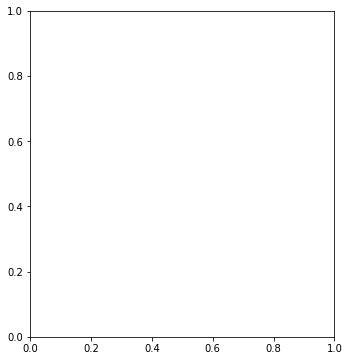

In [15]:
#r = history
r = res
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax1.plot(r.history['loss'], label='loss')
ax1.plot(r.history['val_loss'], label='val_loss')
ax1.legend()
ax2 = plt.subplot(122)
ax2.plot(r.history['accuracy'], label='acc')
ax2.plot(r.history['val_accuracy'], label='val_acc')
ax2.legend()

In [13]:
%%script echo skip this
#sample_str = 'a banach space is defined as complete vector space of some kind .'
#sample_str = 'We define a shushu space as a complete vector space of some kind .'
sample_str = '_display_math_ The Ursell functions of a single random variable X are obtained from these by setting _inline_math_..._inline_math_ .'
sample_pad, _ = prep_data(sample_str, wind, cfg, 'no_tags')
sample_pad = pad_sequences([sample_pad], **cfg['padseq'])
pred = model_bilstm_lstm.predict(sample_pad)
#np.argmax(pred.squeeze(), axis=1)
for i, w in enumerate(sample_pad[0]):
    if wind[w] == '.':
        break
    print(wind[w], np.round(pred)[0][i])
    if wind[w] == '.':
        break

skip this


In [24]:
#preds = model_bilstm_lstm.predict(test_seq)
preds = with_pos.predict([test_seq, test_pos_seq, test_bin_seq])

In [29]:
with_pos.evaluate([test_seq, test_pos_seq, test_bin_seq], test_lab)

41/41 [==============================] - 1s 27ms/step - loss: 0.0324 - accuracy: 0.9883


[0.03243343159556389, 0.9883065223693848]

In [17]:
k = 376
for i in range(len(preds[k])):
    try:
        print('{:<20} {} {:1.2f}'.format(test_def_lst[k]['ner'][i][0][0], 
                                         test_def_lst[k]['ner'][i][1],
                                         round(preds[k][i][0],2)))
    except IndexError:
        break

Nonetheless          O 0.00
,                    O 0.00
in                   O 0.00
the                  O 0.00
common               O 0.00
usage                O 0.01
the                  O 0.00
expulsion            O 0.04
of                   O 0.18
foreign              O 0.37
nationals            O 0.00
is                   O 0.00
usually              O 0.00
called               O 0.00
deportation          B-DFNDUM 0.41
,                    O 0.00
whereas              O 0.00
the                  O 0.00
expulsion            O 0.01
of                   O 0.00
nationals            O 0.00
is                   O 0.00
called               O 0.00
extradition          O 0.45
,                    O 0.00
banishment           O 0.02
,                    O 0.00
exile                O 0.00
,                    O 0.00
or                   O 0.00
penal                O 0.01
transportation       O 0.02
.                    O 0.00


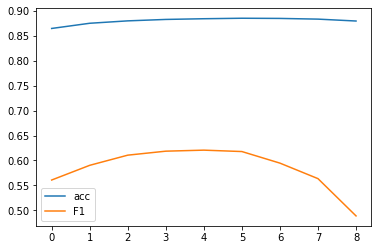

ChunkParse score:
    IOB Accuracy:  88.4%%
    Precision:     63.1%%
    Recall:        61.1%%
    F-Measure:     62.1%%
Cutoff:  0.5


In [25]:
def tf_bio_tagger(tf_pred, tag_def='DFNDUM', tag_o = 'O'):
    '''
    Convert a T/F (binary) Sequence into a BIO tag sequence
    [True, False, False] -> [B-DFNDUM, O, O]
    '''
    begin_tag = 'B-' + tag_def
    inside_tag = 'I-' + tag_def
    out_tag = tag_o
    return_tags = []
    for ind, x in enumerate(tf_pred):
        if x:
            if ind > 0:
                ret = inside_tag if tf_pred[ind - 1] else begin_tag
                return_tags.append(ret)
            else:
                return_tags.append(begin_tag)
        else:
            return_tags.append(out_tag)
    return return_tags
        
def switch_to_pred(test_def_lst, preds, cutoff = 0.5):
    #if len(preds.shape) == 2:
        #case just one prediction (50, 1) 
    #    preds = [preds]
    out_lst = []
    for k, pred in enumerate(preds):
        tf_pred = (pred > cutoff)
        test_def = test_def_lst[k]['ner']
        bio_pred = tf_bio_tagger(tf_pred)
        switched_def_lst = []
        for i in range(len(bio_pred)):    #rate(bio_pred):
            try:
                # test_def[i] example: (('Fock', 'NNP'), 'B-DFNDUM')
                tok_pos = test_def[i][0]
                switched_def_lst.append((tok_pos, bio_pred[i]))
            except IndexError:
                break
        out_lst.append(switched_def_lst)
    return out_lst

def get_chunkscore(CutOFF):
    test_pred_lst = switch_to_pred(test_def_lst, preds, cutoff=CutOFF)
    unpack = lambda l: [(tok, pos, ner) for ((tok, pos), ner) in l]
    Tree_lst_gold = [conlltags2tree(unpack(t['ner'])) for t in test_def_lst]
    Tree_lst_pred = [conlltags2tree(unpack(t)) for t in test_pred_lst]

    chunkscore = ChunkScore()
    for i in range(len(Tree_lst_gold)):
        chunkscore.score(Tree_lst_gold[i], Tree_lst_pred[i])
    return chunkscore
 
#CutOFF = 0.4
#print(get_chunkscore(CutOFF))
#print(f"Cutoff:  {CutOFF}")

data_points = []
BOY_f_score = (0, 0) # (CutOff, score)
for co in np.arange(0.1, 1, 0.1):
    cs = get_chunkscore(co)
    data_points.append((cs.accuracy(), cs.f_measure()))
    if cs.f_measure() > BOY_f_score[1]:
        BOY_f_score = (co, cs.f_measure())

plt.plot(list(zip(*data_points))[0], label='acc')
plt.plot(list(zip(*data_points))[1], label='F1')
plt.legend()
plt.show()

print(get_chunkscore(BOY_f_score[0]))
print(f"Cutoff:  {BOY_f_score[0]}")

In [17]:
#1/5404.0*(np.sum(test_lab*np.log(np.squeeze(preds))) + np.sum((1-test_lab)*np.log(np.squeeze(1-preds))))

In [28]:
# Save and Load models weights
with_pos.save_weights('/home/luis/rm_me_data/with_pos')

In [29]:
with_pos2 = bilstm_lstm_model_w_pos(cfg)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words-in (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
pos-in (InputLayer)             [(None, 50)]         0                                            
__________________________________________________________________________________________________
word-embed (Embedding)          (None, 50, 200)      41688600    words-in[0][0]                   
__________________________________________________________________________________________________
pos-embed (Embedding)           (None, 50, 3)        135         pos-in[0][0]                     
____________________________________________________________________________________________

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /home/luis/rm_me_data/

# get_bilstm_lstm_model Training history
## First working attempt:  commit e4c41f0

Epochs: 70 [01:00<00:00, 3.00s/epoch, loss=0.0513, accuracy=0.98, val_loss=0.0636, val_accuracy=0.975]

* Same attempt but first ChunkScore Epochs: approx 80,  commit: 8a3678c
        ChunkParse score:
            IOB Accuracy:  86.3%%
            Precision:     56.4%%
            Recall:        53.8%%
            F-Measure:     55.1%%
            
## Working attempt with POS: Epochs: 70
    ChunkParse score:
        IOB Accuracy:  85.4%%
        Precision:     53.2%%
        Recall:        47.6%%
        F-Measure:     50.3%%
### Added both LSTMs Bidirectional:
In the previous models the second LSTM layer was not Bidirectional. This makes no sense
loss: 0.0446 - accuracy: 0.9824 - val_loss: 0.0601 - val_accuracy: 0.9770 commit: c53ab68

    ChunkParse score:
        IOB Accuracy:  85.1%%
        Precision:     48.7%%
        Recall:        62.8%%
        F-Measure:     54.9%%
        
With just 150 lstm units. Commit: 53dd596

    ChunkParse score:
        IOB Accuracy:  87.7%%
        Precision:     61.4%%
        Recall:        62.3%%
        F-Measure:     61.8%%
    Cutoff:  0.4
    
Two time dependent dense layers at the end: Commit: 2759216

    ChunkParse score:
        IOB Accuracy:  87.5%%
        Precision:     59.5%%
        Recall:        60.4%%
        F-Measure:     60.0%%
    Cutoff:  0.4
    
## With Binary features: capitalize, has_dash: Commit: 09c6fcb
loss: 0.0408 - accuracy: 0.9840 - val_loss: 0.0547 - val_accuracy: 0.9789

    ChunkParse score:
        IOB Accuracy:  87.1%%
        Precision:     59.2%%
        Recall:        57.9%%
        F-Measure:     58.5%%
    Cutoff:  0.5
    
## Change initializer of POS embedding to Normal mean 0 std 1

TBOY  loss: 0.0299 - accuracy: 0.9884 - val_loss: 0.0539 - val_accuracy: 0.9812

    ChunkParse score:
        IOB Accuracy:  87.3%%
        Precision:     62.5%%
        Recall:        64.2%%
        F-Measure:     63.3%%
    Cutoff:  0.4
    
loss: 0.0201 - accuracy: 0.9922 - val_loss: 0.0531 - val_accuracy: 0.9824 Commit: b3a1c88

    ChunkParse score:
    IOB Accuracy:  87.5%%
    Precision:     68.9%%
    Recall:        64.8%%
    F-Measure:     66.8%%
    Cutoff:  0.6

loss: 0.0362 - accuracy: 0.9855 - val_loss: 0.0489 - val_accuracy: 0.9812 -- 40 epochs. Commit: 0530c59

    ChunkParse score:
        IOB Accuracy:  88.3%%
        Precision:     62.2%%
        Recall:        64.2%%
        F-Measure:     63.2%%
    Cutoff:  0.4

In [18]:
cfg

{'emb_nvocab': 208443,
 'padseq': {'maxlen': 50, 'padding': 'post', 'truncating': 'post'},
 'n_tags': 2,
 'train_test_split': 0.9,
 'nbin_feats': 2,
 'input_dim': 208443,
 'output_dim': 200,
 'input_length': 50,
 'pos_dim': 3,
 'pos_constraint': 0.005,
 'batch_size': 2000,
 'lstm_units': 150,
 'adam': {'lr': 0.025, 'beta_1': 0.9, 'beta_2': 0.999}}